# Сессия 3

### Описание задачи

В этой сессии вы продолжаете работать с данными, подготовленными в предыдущей сессии.
Вам предстоит выполнить регрессионный анализ данных. Модель должна строить предсказания на
среднесрочный период. Какая-либо работа, обусловленная задачами предыдущей сессии,
выполненная в ходе текущей, оцениваться не будет, поэтому проделывайте её только в случае
необходимости.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from pmdarima import auto_arima
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime, timedelta

In [2]:
# считывание набора данных
data = pd.read_csv("output.csv")

In [3]:
data.head(10)

,total_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,RT,LocationID,year,month,day,cluster
0,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,5.0,0
1,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,6.0,0
2,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,7.0,0
3,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,8.0,0
4,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,9.0,0
5,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,10.0,0
6,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,11.0,0
7,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,12.0,0
8,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,13.0,0
9,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,14.0,0


Для работы с временными рядами преобразуем наши параметры "year", "month", "day" обратно в дату.

In [4]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

In [5]:
data.drop(labels=['year', 'month', 'day'], axis=1, index=None, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383698 entries, 0 to 383697
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   total_cases                                 383698 non-null  float64       
 1   new_cases_smoothed                          383698 non-null  float64       
 2   new_deaths                                  383698 non-null  float64       
 3   new_deaths_smoothed                         383698 non-null  float64       
 4   total_cases_per_million                     383698 non-null  float64       
 5   new_cases_per_million                       383698 non-null  float64       
 6   new_cases_smoothed_per_million              383698 non-null  float64       
 7   total_deaths_per_million                    383698 non-null  float64       
 8   new_deaths_per_million                      383698 non-null  float64      

## 3.1 Построение регрессионной модели

Обучение модели будет проводиться по одной локации, так как провести обучение для всех 250 с лишним стран за короткое время не возможно. Необходимо найти усредненную страну возникновения новых заболеваний, для более верного прогнозирования.

Для прогнозирования новых случаев мы будем основываться на данных параметра new_cases_smoothed.

In [7]:
column_to_forecast = 'new_cases_smoothed'

Проверим стационарность модели с помощью теста Дики-Фуллера и выведим все локации, где значение p-value больше 0,05.

In [8]:
# разделим данные на отдельные временные ряды для каждой локации
for location in data['LocationID'].unique():
    location_data = data[data['LocationID'] == location]

    # проверим, является ли временной ряд постоянным
    if location_data['new_cases_smoothed'].nunique() == 1:
        print(f"Warning: Time series for location {location} is constant")
    else:
        # выполним тест Дьюкинга-Фуллера для каждого временного ряда
        adf_test = adfuller(location_data['new_cases_smoothed'])

        # выведем p-value для каждого временного ряда
        if(adf_test[1]>0.05):
            print('p-value for ' + str(location) + ' = ' + str(adf_test[1]))

p-value for 36.0 = 0.14844314676212234
p-value for 70.0 = 0.07582965184604065
p-value for 71.0 = 0.08536962664278402
p-value for 75.0 = 0.24376053876721693
p-value for 82.0 = 0.18894138104640695
p-value for 96.0 = 0.11619861320992225
p-value for 97.0 = 0.07009803546508782
p-value for 125.0 = 0.08093079827018196
p-value for 128.0 = 0.05063735744437314
p-value for 169.0 = 0.05519623239533572
p-value for 209.0 = 0.057836126469680185
p-value for 219.0 = 0.11723179576870968
p-value for 229.0 = 0.05817276424650124
p-value for 246.0 = 0.08777056606854561


Большинство локаций имеют стационарные временные ряды. Это означает, что их среднее значение и дисперсия не меняются со временем, и их можно моделировать с помощью стационарных моделей, таких как ARIMA или SARIMA. Для использования в качестве эталонного региона будет взят регион со стационарным временным отрезком.

Теперь определим страну, в которой случаи новых заболеваний находятся на уровне средних показателей.

In [9]:
# Выбираем столбцы с данными о заболеваемости
columns_to_use = ['LocationID', 'date', 'new_cases_smoothed']
temp_data = data[columns_to_use]

# Группируем данные по странам и дате
grouped = data.groupby(['LocationID', 'date'])

# Вычисляем среднее количество случаев заболевания для каждой страны и даты
means = grouped.mean()

# Вычисляем среднее количество случаев заболевания для каждой страны за весь период
country_means = means.groupby('LocationID').mean()

# Вычисляем среднее количество случаев заболевания для всех стран за весь период
global_mean = means.mean()

# Вычисляем абсолютное отклонение среднего количества случаев заболевания для каждой страны от среднего количества случаев заболевания для всех стран
country_deviations = abs(country_means - global_mean)

# Находим страну с наименьшим абсолютным отклонением
min_country = country_deviations.idxmin()

print("Страна с наиболее близким средним количеством случаев заболевания к среднему количеству заболеваний для всех стран:", min_country)

Страна с наиболее близким средним количеством случаев заболевания к среднему количеству заболеваний для всех стран: total_cases                                   169.0
new_cases_smoothed                              1.0
new_deaths                                    180.0
new_deaths_smoothed                           180.0
total_cases_per_million                       130.0
new_cases_per_million                         231.0
new_cases_smoothed_per_million                231.0
total_deaths_per_million                      165.0
new_deaths_per_million                        112.0
new_deaths_smoothed_per_million               112.0
reproduction_rate                              64.0
new_vaccinations_smoothed_per_million         128.0
new_people_vaccinated_smoothed                178.0
new_people_vaccinated_smoothed_per_hundred    249.0
stringency_index                                1.0
population_density                            165.0
median_age                                      1.0


Теперь оставим полный отрезок времени только для этого региона.

In [36]:
filtered_data = data.loc[data['LocationID'] == 1]

In [37]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 1520 to 3039
Data columns (total 29 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   total_cases                                 1520 non-null   float64       
 1   new_cases_smoothed                          1520 non-null   float64       
 2   new_deaths                                  1520 non-null   float64       
 3   new_deaths_smoothed                         1520 non-null   float64       
 4   total_cases_per_million                     1520 non-null   float64       
 5   new_cases_per_million                       1520 non-null   float64       
 6   new_cases_smoothed_per_million              1520 non-null   float64       
 7   total_deaths_per_million                    1520 non-null   float64       
 8   new_deaths_per_million                      1520 non-null   float64       
 9   new_deaths

In [38]:
filtered_data.head(10)

,total_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,RT,LocationID,cluster,date
1520,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-05
1521,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-06
1522,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-07
1523,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-08
1524,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-09
1525,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-10
1526,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-11
1527,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-12
1528,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-13
1529,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-14


Так как наш временной отрезок стационарный, то мы можем подобрать значения p и q для ARMA модели. 

Построим график ACF

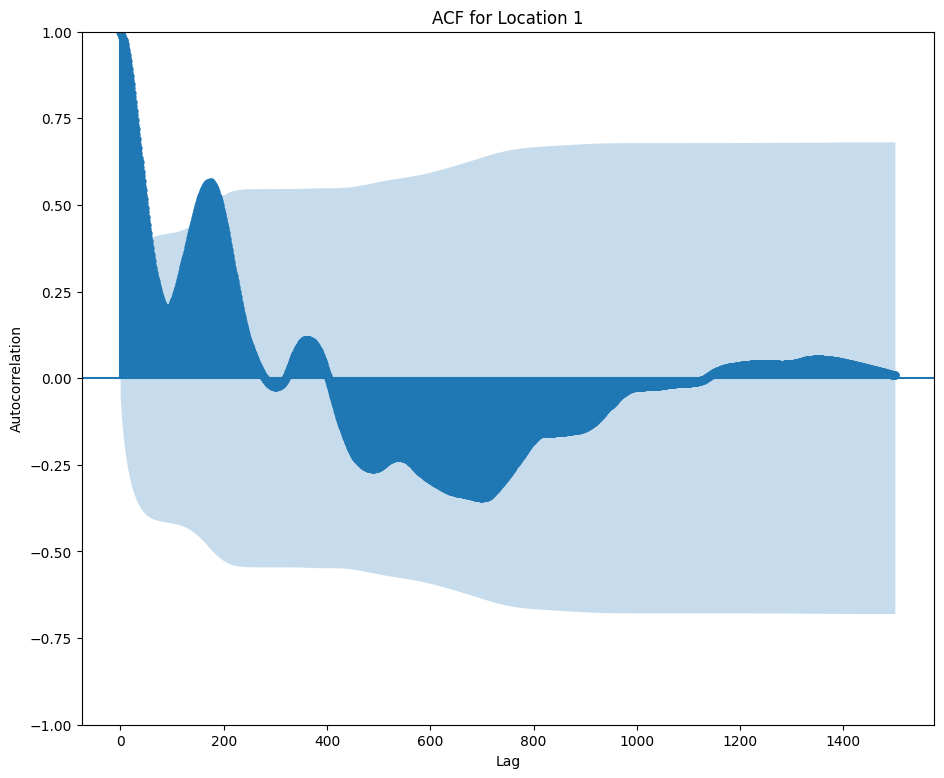

In [39]:
column_to_forecast = 'new_cases_smoothed'
# Построение графика автокорреляции
fig, ax = plt.subplots()
plot_acf(filtered_data[column_to_forecast], lags=1500 , ax=ax)
ax.set_title(f'ACF for Location 1')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
plt.show()


График ACF имеет высокую степень изменчивости, что означает что нам следует использовать меньшие значения атрибута q.

Выведим график PACF

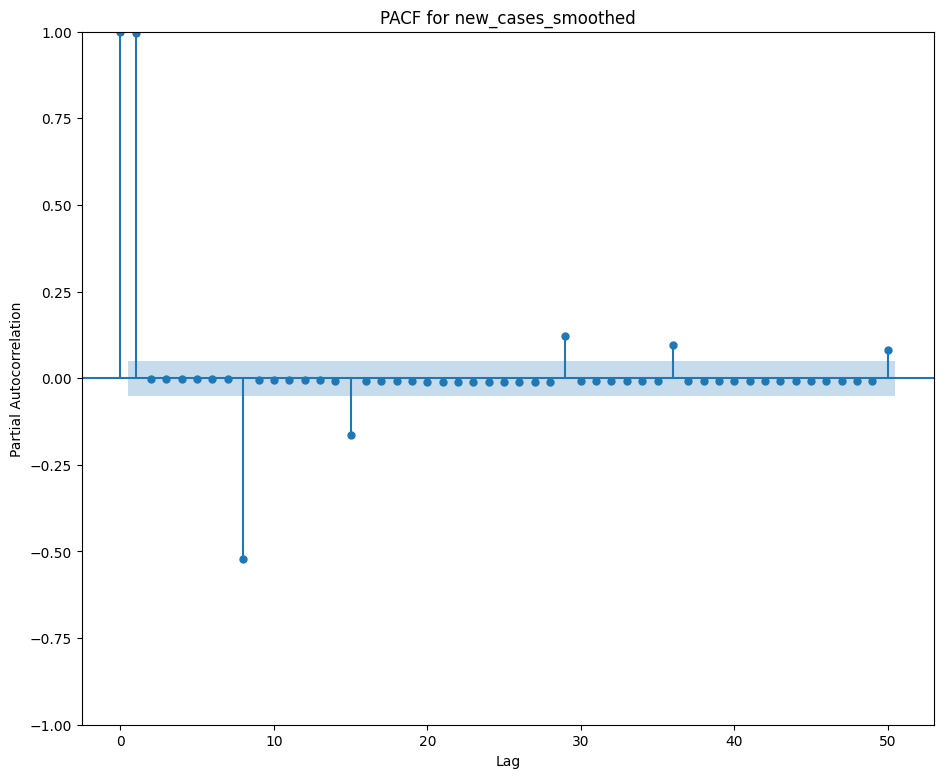

In [40]:
# Построение графика частной автокорреляции
fig, ax = plt.subplots()
plot_pacf(filtered_data[column_to_forecast], lags=50, ax=ax)
ax.set_title(f'PACF for {column_to_forecast}')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')
plt.show()

Так как большая часть параметров не выходит за пределы интервалов стандартного отклонения, то мы можем брать более низкие значения атрибута p.

Несмотря на то, что мы выяснили, что наш временной ряд стационарен, попробуем разбить его на составляющие, такие как сезонность и трендовость

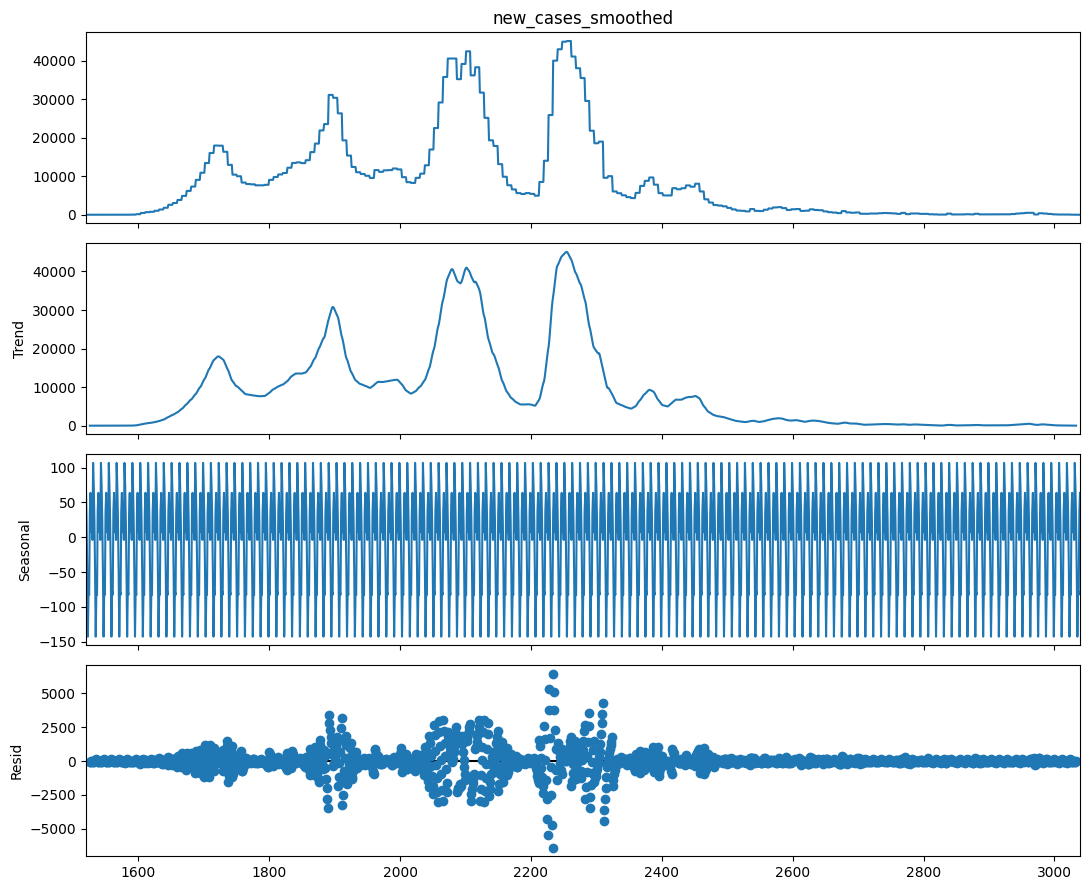

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
 
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
 
# применяем функцию к данным о перевозках
decompose = seasonal_decompose(x=filtered_data["new_cases_smoothed"], period=12)
decompose.plot()
 
plt.show()

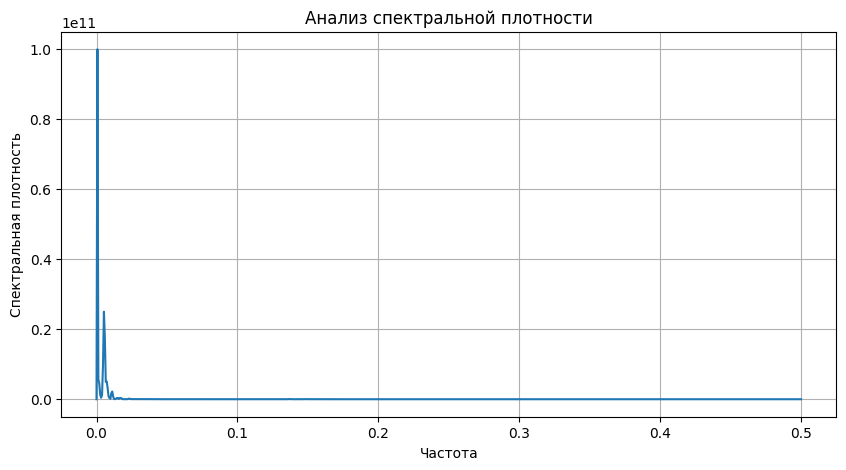

In [48]:
from scipy.signal import periodogram
frequencies, power = periodogram(filtered_data["new_cases_smoothed"], fs=1)

# Выводим график спектральной плотности
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power)
plt.xlabel('Частота')
plt.ylabel('Спектральная плотность')
plt.title('Анализ спектральной плотности')
plt.grid()
plt.show()

### Экспоненциальное сглаживание

In [25]:
exp_train = filtered_data[:int(len(filtered_data) * 0.5)]
exp_test = filtered_data[int(len(filtered_data) * 0.5):]

In [29]:
# Создание экспоненциальной модели
model = ExponentialSmoothing(filtered_data["new_cases_smoothed"], seasonal_periods=7, trend='add', seasonal='add')

# Обучение модели
model_fit = model.fit()

# Вывод прогноза
print(result)

D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


383698    -5.421441
383699    -9.863694
383700   -15.399598
383701   -20.305914
383702   -25.552645
383703   -30.842659
383704   -35.973259
383705   -41.372485
383706   -45.814738
383707   -51.350641
383708   -56.256958
383709   -61.503689
383710   -66.793703
383711   -71.924303
dtype: float64


D:\Python\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [46]:
model_fit.summary()

Dep. Variable:,new_cases_smoothed,No. Observations:,1520
Model:,ExponentialSmoothing,SSE,1328599591.933
Optimized:,True,AIC,20817.007
Trend:,Additive,BIC,20875.598
Seasonal:,Additive,AICC,20817.249
Seasonal Periods:,7,Date:,"Tue, 19 Mar 2024"
Box-Cox:,False,Time:,18:57:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9242857,alpha,True
smoothing_trend,0.0684656,beta,True


In [30]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(exp_train)
 
# и закончится в конце тестового
end = len(exp_train) + len(exp_test) - 1
  
# применим метод predict
predictions = model_fit.predict(start, end)

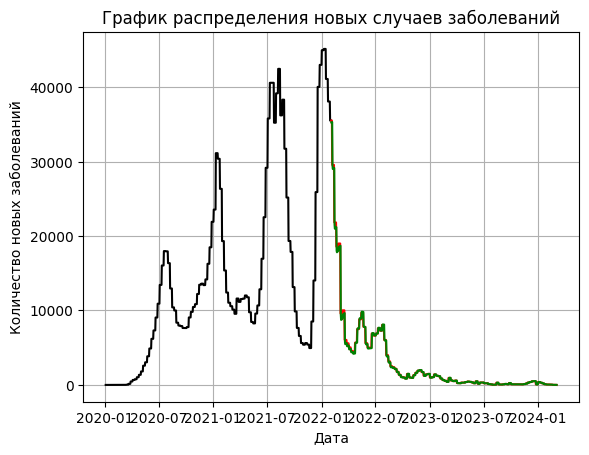

In [31]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(exp_train['date'], exp_train['new_cases_smoothed'], color = "black")
plt.plot(exp_test['date'], exp_test['new_cases_smoothed'], color = "red")
plt.plot(exp_test['date'], predictions, color = "green")
 
# заголовок и подписи к осям
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')


plt.axis('tight')
# добавим сетку
plt.grid()
 
plt.show()

### Модель ARIMA

In [50]:
train = filtered_data[:int(len(filtered_data) * 0.5)]
test = filtered_data[int(len(filtered_data) * 0.5):]

In [ ]:
# Assuming 'train' and 'test' are DataFrames with columns 'date' and 'new_cases_smoothed'
plt.plot(train['date'], train['new_cases_smoothed'], color='red')
plt.plot(test['date'], test['new_cases_smoothed'], color='blue')

# Заголовок и подписи к осям
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')

# Добавим сетку
plt.grid()

plt.show()

Теперь обучим модель ARMA. Для параметров p и q берутся более низкие значения из стандартизированного дипазона от 0 до 5, так как мы выявили это по графикам ACF и PACF. Значение d равно 0, так как модель стационарна.

In [ ]:
train.info()

In [ ]:
# определение порядка дифференцирования
if adfuller(data)[1] > 0.05:
    d = 1
    data_diff = data.diff().dropna()
else:
    d = 0

In [51]:
from pmdarima.arima import auto_arima
# Если модель стационарн
model = auto_arima(train['new_cases_smoothed'], start_p=0, start_q=0,
                   test='adf',       # use adftest to find optimal 'd'
                   max_p=6, max_q=6, # maximum p and q
                   m=1,              # frequency of series
                   d=None,           # let model determine 'd'
                   seasonal=False,   # No Seasonality
                   stepwise=True)    # stepwise model selection

# Если модель нестационарна
model = auto_arima(train['new_cases_smoothed'], start_p=0, start_q=0,
                   test='adf',       # use adftest to find optimal 'd'
                   max_p=6, max_q=6, # maximum p and q
                   m=30,              # frequency of series
                   d=None,           # let model determine 'd'
                   seasonal=True,   # No Seasonality
                   stepwise=True)    # stepwise model selection

# вывод лучших параметров
print('Лучшие параметры: ', model.get_params()['seasonal_order'])


KeyboardInterrupt



In [52]:
# Если модель нестационарна
model = auto_arima(train['new_cases_smoothed'], start_p=0, start_q=0,
                   test='adf',       # use adftest to find optimal 'd'
                   max_p=6, max_q=6, # maximum p and q
                   m=30,              # frequency of series
                   d=None,           # let model determine 'd'
                   seasonal=True,   # No Seasonality
                   stepwise=True)    # stepwise model selection

# вывод лучших параметров
print('Лучшие параметры: ', model.get_params()['seasonal_order'])

Лучшие параметры:  (0, 0, 0, 30)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# create ARMA model
model = ARIMA(train['new_cases_smoothed'], order=(100,0,100))

# fit model
result = model.fit()

In [ ]:

# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)


In [ ]:
predictions.tail()

In [ ]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train['date'], train['new_cases_smoothed'], color = "black")
plt.plot(test['date'], test['new_cases_smoothed'], color = "red")
plt.plot(test['date'], predictions, color = "green")
 
# заголовок и подписи к осям
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')


plt.axis('tight')
# добавим сетку
plt.grid()
 
plt.show()

Несмотря на неточное отображение показателей, модель вполне успешно прогнозировала падение заболеваемости.

In [ ]:
# импортируем метрику
from sklearn.metrics import mean_squared_error
 
# рассчитаем MSE
print(mean_squared_error(test["new_cases_smoothed"], predictions))
 
# и RMSE
print(np.sqrt(mean_squared_error(test["new_cases_smoothed"], predictions)))

### ARIMAX

In [ ]:
# подготовка данных
train = filtered_data[:int(len(filtered_data) * 0.5)]
test = filtered_data[int(len(filtered_data) * 0.5):]
exog_train = train[['exog_var_1', 'exog_var_2', ...]] # добавьте экзогенные переменные
exog_test = test[['exog_var_1', 'exog_var_2', ...]] # добавьте экзогенные переменные

# определение порядка дифференцирования
if adfuller(train['new_cases_smoothed'])[1] > 0.05:
    d = 1
    train_diff = train['new_cases_smoothed'].diff().dropna()
    test_diff = test['new_cases_smoothed'].diff().dropna()
else:
    d = 0
    train_diff = train['new_cases_smoothed']
    test_diff = test['new_cases_smoothed']

# создание модели ARIMAX
model = sm.tsa.statespace.SARIMAX(train_diff, order=(10, d, 1), exog=exog_train, enforcement_stationarity=False, enforcement_invertibility=False)

# обучение модели
result = model.fit()

# прогнозирование
predictions = result.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_test, dynamic=False)

# обратное преобразование прогноза
if d == 1:
    predictions = predictions.cumsum() + train['new_cases_smoothed'].iloc[-1]

# вывод лучших параметров
print('Лучшие параметры: ', result.params)

# вывод графика
plt.plot(train['date'], train['new_cases_smoothed'], color='black')
plt.plot(test['date'], test['new_cases_smoothed'], color='red')
plt.plot(test['date'], predictions, color='green')
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')
plt.axis('tight')
plt.grid()
plt.show()

### SARIMA

In [ ]:
# подготовка данных
train = filtered_data[:int(len(filtered_data) * 0.5)]
test = filtered_data[int(len(filtered_data) * 0.5):]

# определение порядка дифференцирования
if adfuller(train['new_cases_smoothed'])[1] > 0.05:
    d = 1
    train_diff = train['new_cases_smoothed'].diff().dropna()
    test_diff = test['new_cases_smoothed'].diff().dropna()
else:
    d = 0
    train_diff = train['new_cases_smoothed']
    test_diff = test['new_cases_smoothed']

# создание модели SARIMA
model = sm.tsa.statespace.SARIMAX(train_diff, order=(10, d, 1), seasonal_order=(1, 1, 1, 30), enforcement_stationarity=False, enforcement_invertibility=False)

# обучение модели
result = model.fit()

# прогнозирование
predictions = result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# обратное преобразование прогноза
if d == 1:
    predictions = predictions.cumsum() + train['new_cases_smoothed'].iloc[-1]

# вывод лучших параметров
print('Лучшие параметры: ', result.params)

# вывод графика
plt.plot(train['date'], train['new_cases_smoothed'], color='black')
plt.plot(test['date'], test['new_cases_smoothed'], color='red')
plt.plot(test['date'], predictions, color='green')
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')
plt.axis('tight')
plt.grid()
plt.show()

### SARIMAX

In [ ]:
# подготовка данных
train = filtered_data[:int(len(filtered_data) * 0.5)]
test = filtered_data[int(len(filtered_data) * 0.5):]
exog_train = train[['exog_var_1', 'exog_var_2', ...]] # добавьте экзогенные переменные
exog_test = test[['exog_var_1', 'exog_var_2', ...]] # добавьте экзогенные переменные

# определение порядка дифференцирования
if adfuller(train['new_cases_smoothed'])[1] > 0.05:
    d = 1
    train_diff = train['new_cases_smoothed'].diff().dropna()
    test_diff = test['new_cases_smoothed'].diff().dropna()
else:
    d = 0
    train_diff = train['new_cases_smoothed']
    test_diff = test['new_cases_smoothed']

# создание модели SARIMAX
model = sm.tsa.statespace.SARIMAX(train_diff, order=(10, d, 1), seasonal_order=(1, 1, 1, 30), exog=exog_train, enforcement_stationarity=False, enforcement_invertibility=False)

# обучение модели
result = model.fit()

# прогнозирование
predictions = result.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_test, dynamic=False)

# обратное преобразование прогноза
if d == 1:
    predictions = predictions.cumsum() + train['new_cases_smoothed'].iloc[-1]

# вывод лучших параметров
print('Лучшие параметры: ', result.params)

# вывод графика
plt.plot(train['date'], train['new_cases_smoothed'], color='black')
plt.plot(test['date'], test['new_cases_smoothed'], color='red')
plt.plot(test['date'], predictions, color='green')
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')
plt.axis('tight')
plt.grid()
plt.show()

Наилучший результат показала модель экспоненциального сглаживания, показав более точный прогноз на основе тренировочных данных. Поэтому для дальнейшего прогнозирования новых случаев заболевания будет использоваться именно она.

## 3.2 Визуализация работы регрессионной модели

In [33]:
# прогнозный период с конца имеющихся данных
start = len(filtered_data)

# и закончится через 2 месяца
end = start + 60

# теперь построим прогноз на два месяца вперед
forecast = model_fit.predict(start, end)

# посмотрим на прогноз для двух месяцев
print(forecast)

1520     -2.058328
1521     -4.667733
1522     -7.265143
1523     -9.860057
1524    -12.454631
           ...    
1576   -147.356964
1577   -149.966369
1578   -152.563779
1579   -155.158693
1580   -157.753267
Length: 61, dtype: float64


D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


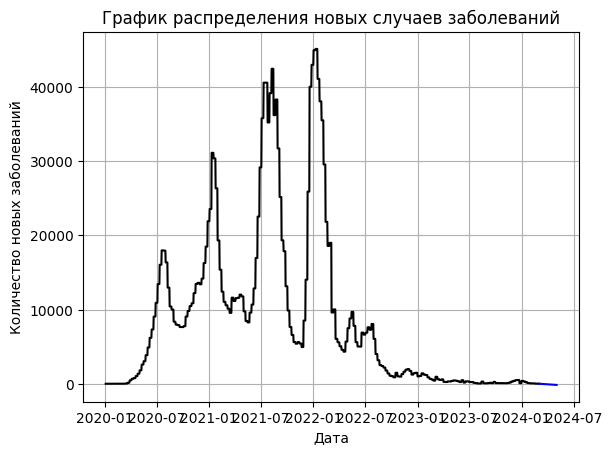

In [34]:
# Получить последнюю дату
last_date = filtered_data['date'].max()

# Добавить два месяца к последней дате
last_date_plus_two_months = last_date + pd.DateOffset(months=2)  - pd.Timedelta(days=1)



# Создать диапазон дат с шагом в один день
date_range = pd.date_range(last_date, last_date_plus_two_months, freq='D')


# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(filtered_data['date'], filtered_data['new_cases_smoothed'], color = 'black')
plt.plot(date_range, forecast, color = 'blue')
 
# заголовок и подписи к осям
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')
 
# добавим сетку
plt.grid()
 
plt.show()